# Coursework 1 : The three body problem

You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

## Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

## Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


## Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


In [1]:
# first we import the libraries we need

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# The following lines makes the plots appear inline in the notebook

%matplotlib inline

## **Stars Class**

Below I have created a 'Stars' Class which allows me to input the initial conditions of each of the stars in the Stellar System. These initial conditions are the mass, x and y position and x and y velocity of the star. I have used asserts here to ensure the stars have a non-negative mass and 2 positional arguments for position and velocity (x and y).

In [2]:
# Star Class

class Stars:
    
    """Definition - a class to contain the stars in our Stellar System
    
       attributes: it's mass, initial position and
       initial velocity
       
       methods: this class has no methods as it holds the stars attributes that the 'Stellar Systems' class will call on
    
    """
    # Setting the initial mass, x and y position and x and y velocity of the star
    
    def __init__(self, mass, initial_position, initial_velocity):
        self.mass = mass
        self.initial_position = initial_position
        self.initial_velocity = initial_velocity
        assert self.mass >= 0.0 , 'You have tried to add a star with negative mass!'
        assert len(self.initial_position) == 2 , 'Your star must be given an x and y position!'
        assert len(self.initial_velocity) == 2 , 'Your star must be given an x and y velocity!'
        if self.mass > 0.0:
            print('You have successfully added a Star to your System! It has a mass of',mass,
              'initial position',str(initial_position),'and initial velocity',str(initial_velocity))
        else:
            print('You have created a star with no mass! This star has crashed and burned and no longer exists, make sure this is your intention!')

## **Stellar Systems Class**

Below I have created a 'Stellar Systems' Class which calculates the motion of the stars in the stellar system. This class is used to solve both the 2 and 3 body problems. When the class is instantiated it will use the stars created in the 'Stars' class, along with the lifetime of orbits. Also, to help with ordering the class has a variable referring to whether the solution has been solved. This is set to false which will be change once solved. I will now explain the methods used in this class:  

- **Calculate_dydt**

  This function will be called by assigning a max time, t (lifetime) and a y, the initial condition vector (y0). Firstly, I define the elements of the 12x1 vector, y, that will hold the positions and velocities of the stars. I also retrieve the mass of the stars from my 'stars' class. I then ensure that $\frac{dy}{dt}$ is the same shape as y so that solve_ivp can solve for each element. Furthemore, I equate what each part of my $\frac{dy}{dt}$ vector will be. This is where I use the ODEs for stars we were given:

  The ODE for the x position for each star is:

  $$\frac{{d^2x_i}}{{dt^2}} = \sum_{j=1, j \neq i}^{N} \frac{{G \cdot M_j}}{{r_{ij}^2}} \cdot \cos(\theta)$$

  As the x position equation is $\frac{du}{dt}$ we need it to match up with where u is in the y vector for each 3 stars. This equates to the 3rd, 7th and 11th element of the $\frac{dy}{dt}$ vector. 

  And the for the y position:

  $$\frac{{d^2y_i}}{{dt^2}} = \sum_{j=1, j \neq i}^{N} \frac{{G \cdot M_j}}{{r_{ij}^2}} \cdot \sin(\theta)$$

  As the y position equation is $\frac{dv}{dt}$ we need it to match up with where v is in the y vector for each 3 stars. This equates to the 4th, 8th and 12th element of the $\frac{dy}{dt}$ vector.

  Where:

  - $r_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$
    
  - $\cos(\theta) = \frac{x_j - x_i}{r_{ij}}$
    
  -  $\sin(\theta) = \frac{y_j - y_i}{r_{i}}$

  ignore this ---> e an if statement   

- **Integrate Using Solve-Ivp**

The Solve_ivp function solves 'initial value problems' for ODEs by finding a solution, y that satisfies the ODE given certain initial conditions. This function will be called through assigning a number of steps for solve ivp to take until it reaches its max time (lifetime). Before using solve_ivp, I calculated the t solution at each step between 0 and the lifetime. Solve_ivp then integrates $\frac{dy}{dt}$ finding the y solution at each time step. This is the general code for the Solve_Ivp function:
~~~
solve_ivp(f, tspan, y0, t_eval=None, **options)
~~~
where:
 - f is the function defining the ODE which in this case is the function calculated in my caluclate_dydt function
 - tspan is the time span in which the ODE is integrated which in this case is from 0 to the lifetime of orbits
 - y0 is the initial conditions which will be inputted when instantiating the class
 - t_eval specifies which time points to store the results which here will be the t solution

I lowered the relative tolerance (rtol) from $1e^-6$ to $1e^-10$ to acheive a more accurate and smoother solution. Finally at the end of the function I change my 'solution_solved' variable to true, now that we have a solution. 

- **Integration Using the Midpoint Method**

The midpoint method is another way to solve ODEs which is modified from the Euler method. This method is an improvement on the Euler method as it achieves stability by using the gradient at a half time step and using that to compute the full step gradient. My function starts again by passing in a number of steps set by the user, which is used in the same way as above to find the t solution. The next part of the function is where I form a zeros matrix for the y solution which has rows like the initial conditions and columns like the t solutions. 

Once I have the matrix set up, I start by working out the y value at the midpoint using this formula:

$$y_{k+\frac{1}{2}} = y_k + \frac{1}{2} \cdot h \cdot f(y_k, t_k)$$
where$$f = \frac{dy}{dt}$$

Which is put into my code here: 
~~~
y_t_plus_half = (self._solution_y[:,itime-1] + 0.5 * self.delta_t * dydt_at_t)
~~~

Then after calculating $\frac{dy}{dt}$ at t plus half, I used this formula to find the y value at the full step:

$$y_{k+1} = y_k + h \cdot f(y_{k+\frac{1}{2}}, t_{k+\frac{1}{2}})$$

Which is used in my code here:
~~~
self._solution_y[:,itime] = (self._solution_y[:,itime-1] + self.delta_t * dydt_at_t_plus_half) 
~~~
Again, at the end of the function I can now change my 'solution_solved' variable to True now we have found a solution.



- **Plot Solutions**

In my plot solutions function I first assert that I have found a solution before I attempt to plot. I have then introduced an if statement to check whether a third star exists or not. If so I plot the x and y positions for 3 stars, else I plot the x and y position for 2 stars. 

- **Phase Plots**

I have made two phase plot functions. The first function plots the y position against the y velocity which is $\frac{dy}{dt}$, for each star. The second, plots the x position against the x velocity which is $\frac{dx}{dt}$, for each star. In my phase plot function I also assert that a solution has been found and include an if statement to check if a third star exists and to plot accordingly.

In [3]:
# Stellar Systems Class

class Stellar_Systems:

    """Definition - a class to represent the motion of the two stars

       attributes: initial conditions of the stars, lifetime of oscillations, private attributes for the solutions

       methods: solve the two and three body problem, plots of the orbital trajectories of the stars over time using solve_ivp() 
                and the midpoint method and phase diagrams for the position and velocities of the component stars.
    """
    # constrcutor function
    def __init__(self, star1, star2, star3, lifetime) :
        self.star1 = star1
        self.star2 = star2
        self.star3 = star3
        self.lifetime = lifetime
        self._solution_y = []
        self._solution_t = []
        self._solution_solved = False 
        
    def integrate_using_solve_ivp(self, N_time_steps) :
        self.delta_t = self.lifetime / N_time_steps # change in t = t / number of time steps
        t_solution = np.linspace(0.0, self.lifetime, N_time_steps+1) 
        #y0 are the initial conditions we will set below
        solution = solve_ivp(self.calculate_dydt, [0,self.lifetime],
                        y0, t_eval=t_solution, rtol = 1e-10) # I have lowered the rtol parameter to make solve_ivp more accurate 
        self._solution_t = solution.t
        self._solution_y = solution.y
        self._solution_solved = True

    def integrate_using_midpoint(self, N_time_steps) :
        self.delta_t = self.lifetime / N_time_steps
        t_solution = np.linspace(0.0, self.lifetime, N_time_steps+1)
        self._solution_t = t_solution 

        # the length of the vector y0 (the initial conditions) will be the number of rows in our matrix which should equal 12
        rows = len(y0) 
        # the length of the vector of t solutions will be the columns of our matrix which we calculated above
        columns = len(self._solution_t)
        # assigning a matrix of zeros with the lengths found above to the y solution 
        self._solution_y = np.zeros((rows,columns))

        # creating a for loop where we will append solutions to y into our matrix above 
        for itime, time in enumerate(self._solution_t) :
            # when t = 0 we want the solution of y to be the initial conditions of our stars
            if itime == 0 :
                self._solution_y[:,itime] = y0
                old_time = time
            else :
                # calculating dy/dt at t = i and y(t = i - 1) where y is a 12x1 vector
                dydt_at_t = self.calculate_dydt(old_time, self._solution_y[:,itime-1])
                # finding y(t = i-1/2)
                y_t_plus_half = (self._solution_y[:,itime-1] + 0.5 *
                                         self.delta_t * dydt_at_t)
                t_plus_half = old_time + 0.5 * self.delta_t
                # calculating te midpoint gradient, dy/dt at t = i + 1/2 and y(t = i - 1/2) 
                dydt_at_t_plus_half = self.calculate_dydt(t_plus_half, y_t_plus_half)
                # using the midpoint gradient to find y and append to the ith column of the matrix
                self._solution_y[:,itime] = (self._solution_y[:,itime-1] + 
                                            self.delta_t * dydt_at_t_plus_half) 
                old_time = time
            self._solution_solved = True
        
    def calculate_dydt(self, t, y) :
        # Define variables to make caluclations more readable
        x_t = y[0] 
        y_t = y[1]
        u_t = y[2]
        v_t = y[3]
        x2_t = y[4]
        y2_t = y[5]
        u2_t = y[6]
        v2_t = y[7]
        x3_t = y[8]
        y3_t = y[9]
        u3_t = y[10]
        v3_t = y[11]
        # using the star class here to introduce the masses for the stars
        m1 = self.star1.mass
        m2 = self.star2.mass
        m3 = self.star3.mass

        # create a vector the same shape as y filled with zeros - this should be a 12x1 vector
        dydt = np.zeros_like(y)
        
        # This is dxdt, which is just u (the x velocity) for star 1
        dydt[0] = u_t
        # This is dydt, which is just v (the y velocity) for star 1
        dydt[1] = v_t
       
        # This is dudt, which is the x position equation for star 1
        # the if statement here assesses if a 3rd star has been inputted that has a mass greater than 0 
        if m3 > 0:
            # if so then use the ODE for 3 stars 
            dydt[2] = sum([(m2 * (x2_t - x_t)) / (np.sqrt((x_t - x2_t)**2 + (y_t - y2_t)**2))**3 , 
                      (m3 * (x3_t - x_t)) / (np.sqrt((x_t - x3_t)**2 + (y_t - y3_t)**2))**3])
        else:
            # if not use the ODE for 2 stars
            dydt[2] = (m2 * (x2_t - x_t)) / (np.sqrt((x_t - x2_t)**2 + (y_t - y2_t)**2))**3
        
        #This is dvdt, which is the y position equation for star 1
        if m3> 0:
            dydt[3] = sum([(m2 * (y2_t - y_t)) / (np.sqrt((x_t - x2_t)**2 + (y_t - y2_t)**2))**3 , 
                      (m3 * (y3_t - y_t)) / (np.sqrt((x_t - x3_t)**2 + (y_t - y3_t)**2))**3])
        else:
            dydt[3] = (m2 * (y2_t - y_t)) / (np.sqrt((x_t - x2_t)**2 + (y_t - y2_t)**2))**3
        
        # This is dx2dt, which is just u (the x velocity) for star 2
        dydt[4] = u2_t
        # This is dy2dt, which is just v (the y velocity) for star 2
        dydt[5] = v2_t
        
        # This is du2dt, which is the x position equation for star 2
        if m3 > 0:
            dydt[6] = sum([(m1 * (x_t - x2_t)) / (np.sqrt((x2_t - x_t)**2 + (y2_t - y_t)**2))**3 , 
                      (m3 * (x3_t - x2_t)) / (np.sqrt((x2_t - x3_t)**2 + (y2_t - y3_t)**2))**3])
        else:
            dydt[6] = (m1 * (x_t - x2_t)) / (np.sqrt((x2_t - x_t)**2 + (y2_t - y_t)**2))**3
       
        #This is dv2dt, which is the y position equation for star 2
        if m3 > 0:
            dydt[7] = sum([(m1 * (y_t - y2_t)) / (np.sqrt((x2_t - x_t)**2 + (y2_t - y_t)**2))**3 , 
                      (m1 * (y3_t - y2_t)) / (np.sqrt((x2_t - x3_t)**2 + (y2_t - y3_t)**2))**3])
        else:
            dydt[7] = (m1 * (y_t - y2_t)) / (np.sqrt((x2_t - x_t)**2 + (y2_t - y_t)**2))**3
       
        # This is dx3dt, which is just u (the x velocity) for star 3
        dydt[8] = u3_t
        # This is dy3dt, which is just v (the y velocity) for star 3
        dydt[9] = v3_t
        # This is du3dt, which is the x position equation for star 3
        dydt[10] = sum([(m1 * (x_t - x3_t)) / (np.sqrt((x3_t - x_t)**2 + (y3_t - y_t)**2))**3 , 
                      (m2 * (x2_t - x3_t)) / (np.sqrt((x3_t - x2_t)**2 + (y3_t - y2_t)**2))**3])
        # This is dv3dt, which is the y position equation for star 3
        dydt[11] = sum([(m1 * (y_t - y3_t)) / (np.sqrt((x3_t - x_t)**2 + (y3_t - y_t)**2))**3 , 
                      (m2 * (y2_t - y3_t)) / (np.sqrt((x3_t - x2_t)**2 + (y3_t - y2_t)**2))**3]) 
        return dydt
                
    def plot_solution(self) :
        # plotting the orbital trajectories of the x and y position of the stars over time
        # if there is a 3rd star then plot 3 stars
        assert self._solution_solved, 'The solution must be found before plotting'
        if self.star3.mass > 0:
            plt.grid()
            plt.xlabel("x", fontsize=16)
            plt.ylabel("y", fontsize=16) 
            plt.plot(self._solution_y[0], self._solution_y[1], 'r-', label = 'Star 1')
            plt.plot(self._solution_y[4], self._solution_y[5], 'g-', label = 'Star 2')
            plt.plot(self._solution_y[8], self._solution_y[9], 'b-', label = 'Star 3')
            plt.legend()
        # if not plot 2 stars
        else:
            plt.grid()
            plt.xlabel("x", fontsize=16)
            plt.ylabel("y", fontsize=16) 
            plt.plot(self._solution_y[0], self._solution_y[1], 'r-', label = 'Star 1')
            plt.plot(self._solution_y[4], self._solution_y[5], 'g-', label = 'Star 2')
            plt.legend()
        
    def plot_phase_plot_y(self) :
        # plotting the phase diagram for the y position and y velocity of the stars
        assert self._solution_y.size != 0, 'The solution must be found before plotting'
        if self.star3.mass > 0:
            plt.grid()
            plt.xlabel("y", fontsize=16)
            plt.ylabel("v", fontsize=16) 
            plt.plot(self._solution_y[1], self._solution_y[3], 'r-', label = 'Star 1') 
            plt.plot(self._solution_y[5], self._solution_y[7], 'g-', label = 'Star 2')
            plt.plot(self._solution_y[9], self._solution_y[11], 'b-', label = 'Star 3')
            plt.legend()

        else:
            plt.grid()
            plt.xlabel("y", fontsize=16)
            plt.ylabel("v", fontsize=16) 
            plt.plot(self._solution_y[1], self._solution_y[3], 'r-', label = 'Star 1') 
            plt.plot(self._solution_y[5], self._solution_y[7], 'g-', label = 'Star 2')
            plt.legend()

    def plot_phase_plot_x(self) :
        # plotting the phase diagram for the x position and x velocity of the stars
        assert self._solution_y.size != 0, 'The solution must be found before plotting'
        if self.star3.mass > 0:
            plt.grid()
            plt.xlabel("x", fontsize=16)
            plt.ylabel("u", fontsize=16) 
            plt.plot(self._solution_y[0], self._solution_y[2], 'r-', label = 'Star 1') 
            plt.plot(self._solution_y[4], self._solution_y[6], 'g-', label = 'Star 2')
            plt.plot(self._solution_y[8], self._solution_y[10], 'b-', label = 'Star 3')
            plt.legend()
            
        else:
            plt.grid()
            plt.xlabel("x", fontsize=16)
            plt.ylabel("u", fontsize=16) 
            plt.plot(self._solution_y[0], self._solution_y[2], 'r-', label = 'Star 1') 
            plt.plot(self._solution_y[4], self._solution_y[6], 'g-', label = 'Star 2')
            plt.legend()

### **Setting of Initial Conditions for the Two Body Problem**

Below I start by setting initial conditions for my stars, making sure they are valid inputs. Then, I make an instance of my 'stars' class and add the stars to the system. Next, I combine the initial values into a 12x1 array as this is what my class is expecting and I make sure that each element is in the correct row. Finally, I make an instance of my 'Stellar Systems' class using the stars and a lifetime that I have set to 22, as this gave a nice orbit.

In [4]:
# Star Masses
star1_mass = 0.40
star2_mass = 0.80
star3_mass = 0.0 # set star 3 to mass zero to show that it doesn't exist

# Initial Positions and Velocities of Stars
star1_initial_position = np.array([1.0,1.0])
star1_initial_velocity = np.array([0.0,-0.40])
star2_initial_position = np.array([-1.0,-1.0])
star2_initial_velocity = np.array([0.0,0.20])
star3_initial_position = np.array([0.0,0.0])
star3_initial_velocity = np.array([0.0,0.0])

# Instantiating my Star Class using the initial values above to create the two bodies
my_star1 = Stars(star1_mass, star1_initial_position, star1_initial_velocity) 
my_star2 = Stars(star2_mass, star2_initial_position, star2_initial_velocity)
my_star3 = Stars(star3_mass, star3_initial_position, star3_initial_velocity)

# Combining the initial values of my stars into a 12x1 array 
y0 = np.array([star1_initial_position[0], star1_initial_position[1],
               star1_initial_velocity[0], star1_initial_velocity[1],
               star2_initial_position[0], star2_initial_position[1],
               star2_initial_velocity[0], star2_initial_velocity[1],
               star3_initial_position[0], star3_initial_position[1],
               star3_initial_velocity[0], star3_initial_velocity[1]])

assert len(y0) == 12 , 'Initial Conditions must have length 12'

lifetime = 22 # setting the lifetime of the orbit

# Instantiating my Stellar System Class using the Stars I have made
my_stellar_system = Stellar_Systems(my_star1, my_star2, my_star3, lifetime)

You have successfully added a Star to your System! It has a mass of 0.4 initial position [1. 1.] and initial velocity [ 0.  -0.4]
You have successfully added a Star to your System! It has a mass of 0.8 initial position [-1. -1.] and initial velocity [0.  0.2]
You have created a star with no mass! This star has crashed and burned and no longer exists, make sure this is your intention!


#### **Tests of Asserts**

Below I have tested my asserts by entering values that should be given back as an error, and I have also tested the order of my code by trying to plot the solution before solving. If you uncomment the code for each test it will present my assertion error. 

In [5]:
#Test Number 1: Mass of the stars must be non-negative
#negative_mass_star1 = -0.40
#my_negative_mass_star1 = Stars(negative_mass_star1, star1_initial_position, star1_initial_velocity) 

In [6]:
#Test Number 2: Initial Position must have x and y
#star1_incorrect_initial_position = np.array([1.0])
#my_star1 = Stars(star1_mass, star1_incorrect_initial_position, star1_initial_velocity) 

In [7]:
#Test Number 3: Initial Velocity must have x and y
#star1_incorrect_initial_velocity = np.array([1.0])
#my_star1 = Stars(star1_mass, star1_initial_position, star1_incorrect_initial_velocity)

In [8]:
# Test Number 4: Solution must be found before plotting
#my_stellar_system.plot_solution()

### **Integrating using the Solve-ivp Method and Plotting the orbital trajectories of the two body problem**

Here, I have called the integrate using solve_ivp fucntion in my 'Stellar Systems' class. By setting the steps to a large number, I achieve a smoother  orbits as it solves at more time steps. When plotting the solution we should see 2 stars in a stable orbit of each other. If we do see this then that is a good way to test the code is working. Note that the reason the orbits stay fixed is that the equation $m_1v_1 = m_2v_2$ is satisfied. Where $m_1$, $m_2$ are the masses of star 1 and star 2 respectively and $v_1$, $v_2$ are the velocities of star 1 and star 2 respectively.

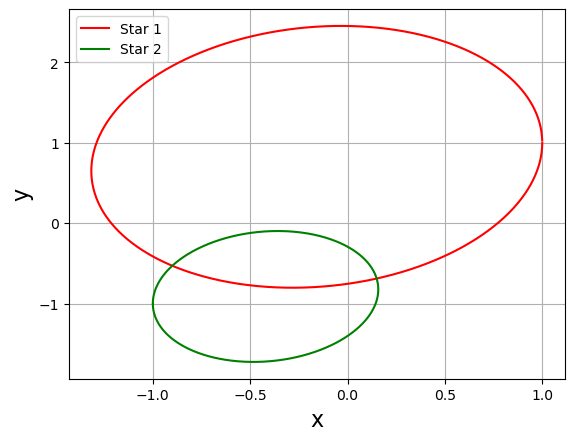

In [9]:
steps = 1000
my_stellar_system.integrate_using_solve_ivp(steps)
my_stellar_system.plot_solution()

### **Phase Plots**

Below I have plotted two phase plots. The first being the y position of each star plotted against the y velocity of each star, which is $\frac{dy}{dt}$ or just v. The second being the x position of each star plotted against the x velocity of each star, which is $\frac{dx}{dt}$ or just u.

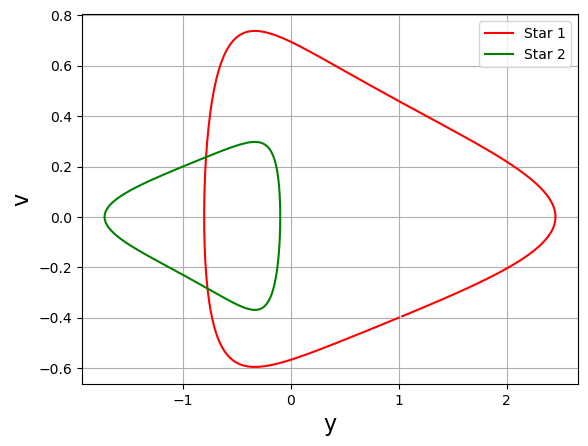

In [10]:
my_stellar_system.plot_phase_plot_y()

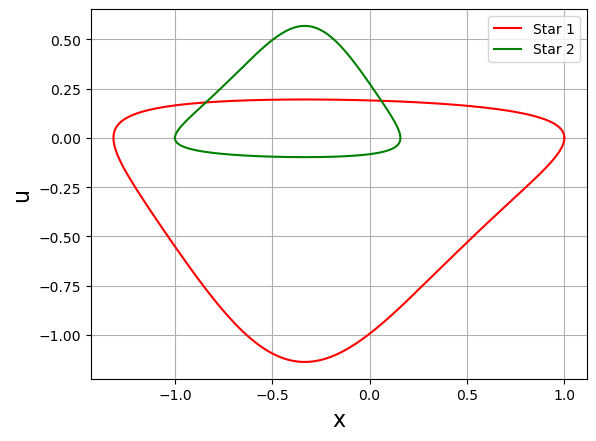

In [11]:
my_stellar_system.plot_phase_plot_x()

### **Integration using the Midpoint Method and Plotting Orbital Trajectories**

Below I have created another stellar system with the same conditions to make sure the ODE's are solved using the midpoint method and to show that I get the same result as solve_ivp.

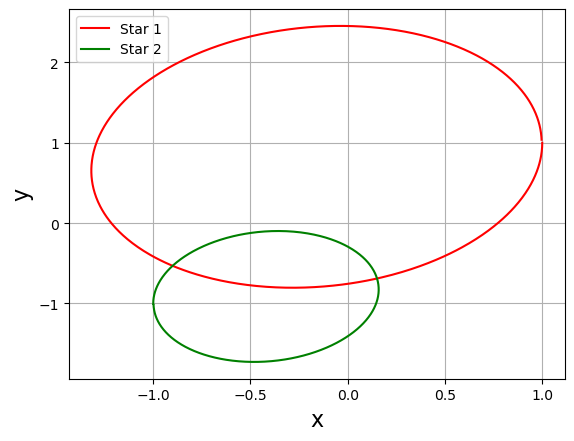

In [12]:
# Instantiating a second Stellar System with the same initial conditions to integrate using the midpoint method
my_stellar_system2 = Stellar_Systems(my_star1 , my_star2, my_star3, lifetime)
my_stellar_system2.integrate_using_midpoint(steps)
my_stellar_system2.plot_solution()

### **Test of Convergence for the Midpoint Method**

As the Midpoint Method is a second order method, the error should decrease by a factor of 4 when halving the step size. This is shown here:

$$\frac{y_{N=1000} - y_{N=500}}{y_{N=500} - y_{N=250}} \quad = \frac{1}{4}$$    

The plot below should show the error between the solutions at 1000 and 500 steps decreasing by a factor of 4 compared to the error between the solutions at 500 and 250 steps. The orange dotted line represents the expected error, calculated by dividing the error between the solutions at 500 and 250 steps by 4. The closer our green line, representing the error between the solutions at 1000 and 500 steps is to the dotted orange the line, the better the convergence is.

Running this code shows that my green line is very close to the expected error, therefore suggesting that my midpoint method is working correctly.

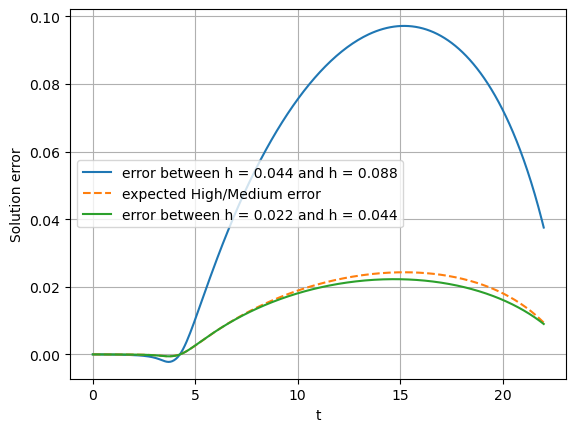

In [13]:
# error should decrease by factor of 4 as the midpoint is a second order method
order = 2.0 ** 2.0
N_steps_vector = [250,500,1000]
for isteps, N_steps in enumerate(N_steps_vector) :

    steps = N_steps
    my_stellar_system2.integrate_using_midpoint(steps)
    h = my_stellar_system2.delta_t # set h equal to the change in t which is the lifetime (22) / steps
    if isteps > 0 :
        # take every other column of the first row of the matrix solution y 
        # so that it has the same shape as the old solution
        diff = my_stellar_system2._solution_y[0,::2] - old_solution 
        plt.plot(my_stellar_system2._solution_t[::2], diff,
                 label="error between h = " + str(h) + " and h = " + str(h*2))  
        if isteps == 1 :
            plt.plot(my_stellar_system2._solution_t[::2], diff / order, '--', 
                     label="expected High/Medium error" )
    old_solution = my_stellar_system2._solution_y[0] # here I have chosen to look at the first row
plt.grid()
plt.legend()
plt.ylabel("Solution error")
plt.xlabel("t");

## **Three Body Problem (using solve_ivp)**

For the 3 body problem, I have used the same approach as the 2 body problem but I have to input a mass for the third star. Also, I have changed the initial conditions of the stars, using the values set out by Chenciner and Montgomery (found here: https://arxiv.org/abs/math/0011268) to be able to achieve a stable solution for the 3 body problem.

What we should see here when we plot is that the 3 stars are in a stable orbit of each other in a figure of 8 (or infinity symbol) like shape. If this is the case then that's a good test that the code is working. 

You have successfully added a Star to your System! It has a mass of 1.0 initial position [ 0.97000436 -0.24308753] and initial velocity [0.46620368 0.43236573]
You have successfully added a Star to your System! It has a mass of 1.0 initial position [-0.97000436  0.24308753] and initial velocity [0.46620368 0.43236573]
You have successfully added a Star to your System! It has a mass of 1.0 initial position [0. 0.] and initial velocity [-0.93240737 -0.86473146]


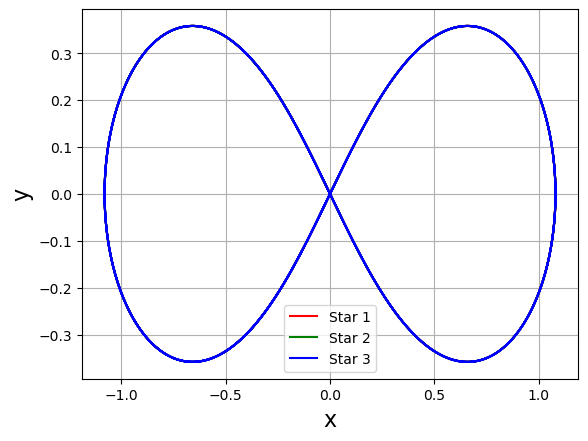

In [14]:
# Setting the 3 bodies to have equal masses
star1_mass = 1.00
star2_mass = 1.00
star3_mass = 1.00

# Initial Positions and Velocities of the stars using the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery 
# found here: https://arxiv.org/abs/math/0011268
star1_initial_position = np.array([0.97000436,-0.24308753])
star1_initial_velocity = np.array([(-0.93240737/2)*-1,(-0.86473146/2)*-1])
star2_initial_position = np.array([-0.97000436,0.24308753])
star2_initial_velocity = np.array([(-0.93240737/2)*-1,(-0.86473146/2)*-1])
star3_initial_position = np.array([0.0,0.0])
star3_initial_velocity = np.array([-0.93240737,-0.86473146])

# Instantiating my Star Class using the initial values above to create the three bodies
my_star1 = Stars(star1_mass, star1_initial_position, star1_initial_velocity) 
my_star2 = Stars(star2_mass, star2_initial_position, star2_initial_velocity)
my_star3 = Stars(star3_mass, star3_initial_position, star3_initial_velocity)

# Combining the initial values of my stars into a 12x1 array 
y0 = np.array([star1_initial_position[0], star1_initial_position[1],
               star1_initial_velocity[0], star1_initial_velocity[1],
               star2_initial_position[0], star2_initial_position[1],
               star2_initial_velocity[0], star2_initial_velocity[1],
               star3_initial_position[0], star3_initial_position[1],
               star3_initial_velocity[0], star3_initial_velocity[1]])
lifetime = 20

# Instantiating a 3 body Stellar System Class using the Stars I have made
my_3_body_stellar_system = Stellar_Systems(my_star1, my_star2, my_star3, lifetime)  

# Plotting the 3 body problem
steps = 1000
my_3_body_stellar_system.integrate_using_solve_ivp(steps)
my_3_body_stellar_system.plot_solution()

### **Three Body Problem using midpoint method**

A working midpoint method should plot the same infinity symbol shape for the solution, which we see here.

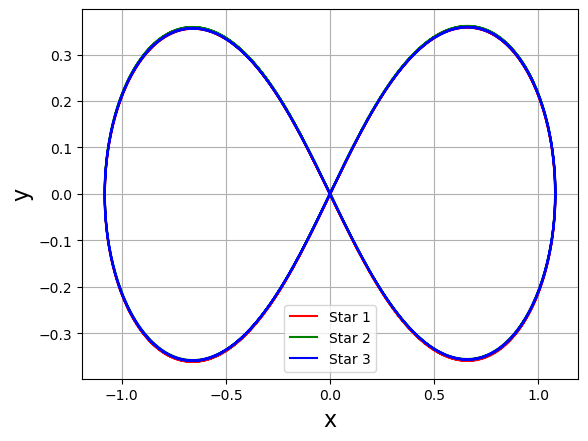

In [15]:
# Instantiating a new 3 body Stellar System Class using the Stars I have made
my_3_body_stellar_system2 = Stellar_Systems(my_star1, my_star2, my_star3, lifetime)  

# Plotting the 3 body problem with the midpoint method
steps = 1000
my_3_body_stellar_system2.integrate_using_midpoint(steps)
my_3_body_stellar_system2.plot_solution()

### **Phase Plots for the 3 Body Problem**

The phase plots below show the stabilty of the 3 body solution.

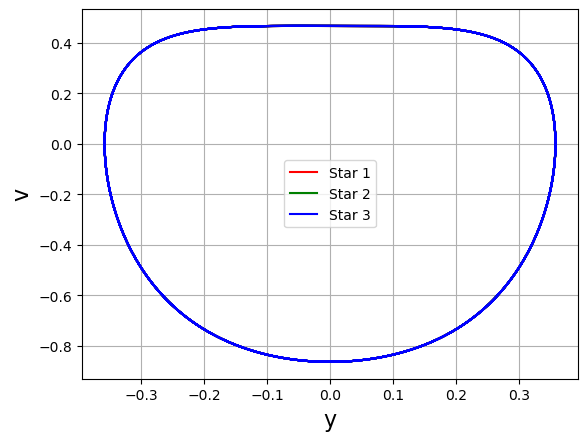

In [16]:
my_3_body_stellar_system.plot_phase_plot_y()

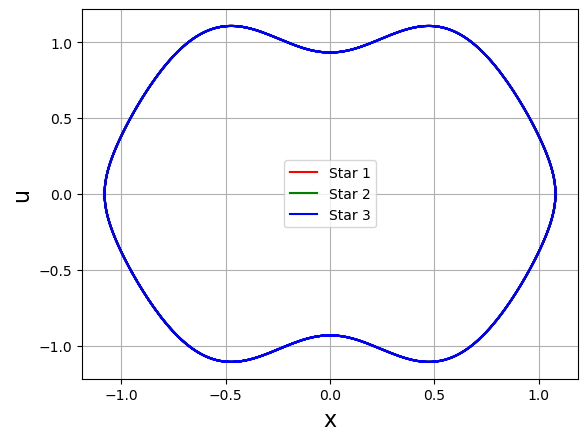

In [17]:
my_3_body_stellar_system.plot_phase_plot_x()

## **A Three Body System displaying chaotic behaviour, with one star being ejected from the system**

Here, I have changed the initial conditions of the 3 body problem to show choatic behaviour. I have kept the masses the same for all stars, giving them all the same velocity and to keep them equidistant from the center of space. I did this after researching that if stars of 'comparable size and distance from a center point in space orbit each other, the system is thrown into chaos' (found here: https://www.amnh.org/explore/news-blogs/research-posts/cracking-the-three-body-problem-with-chaos).

Choatic behvaiour should be shown in the plot by one star being thrown out of the orbit whilst the other two stars continue to orbit around each other. 

You have successfully added a Star to your System! It has a mass of 1.0 initial position [-1.  1.] and initial velocity [ 1. -1.]
You have successfully added a Star to your System! It has a mass of 1.0 initial position [ 1. -1.] and initial velocity [ 1. -1.]
You have successfully added a Star to your System! It has a mass of 1.0 initial position [-1.  0.] and initial velocity [ 1. -1.]


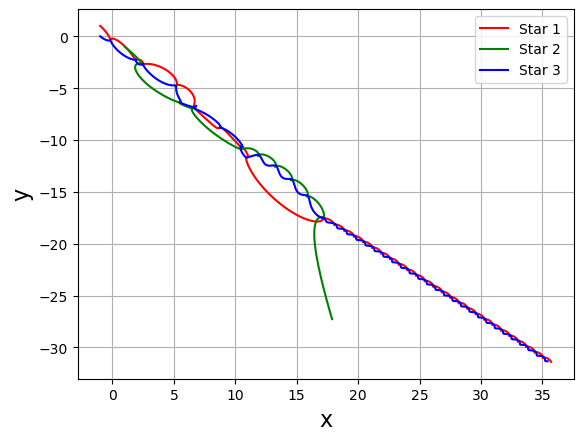

In [18]:
# Keeping the bodies having equal masses
star1_mass = 1.00
star2_mass = 1.00
star3_mass = 1.00

# Initial Positions and Velocities of Stars
star1_initial_position = np.array([-1.0,1.0])
star1_initial_velocity = np.array([1.0,-1.0])
star2_initial_position = np.array([1.0,-1.0])
star2_initial_velocity = np.array([1.0,-1.0])
star3_initial_position = np.array([-1.0,0.0])
star3_initial_velocity = np.array([1.0,-1.0])

# Instantiating my Star Class using the initial values above to create the two bodies
my_star1 = Stars(star1_mass, star1_initial_position, star1_initial_velocity) 
my_star2 = Stars(star2_mass, star2_initial_position, star2_initial_velocity)
my_star3 = Stars(star3_mass, star3_initial_position, star3_initial_velocity)

# Combining the initial values of my stars into a 12x1 array 
y0 = np.array([star1_initial_position[0], star1_initial_position[1],
               star1_initial_velocity[0], star1_initial_velocity[1],
               star2_initial_position[0], star2_initial_position[1],
               star2_initial_velocity[0], star2_initial_velocity[1],
               star3_initial_position[0], star3_initial_position[1],
               star3_initial_velocity[0], star3_initial_velocity[1]])

lifetime = 30

# Instantiating my Stellar System Class using the Stars I have made
my_3_body_stellar_system3 = Stellar_Systems(my_star1, my_star2, my_star3, lifetime)  
steps = 1000
my_3_body_stellar_system3.integrate_using_solve_ivp(steps)
my_3_body_stellar_system3.plot_solution()

#### **Phase Plot for Chaotic Behaviour**

Below should show a very chaotic phase plot showing how unstable the 3 bodies are. This emphasises the stability of the phase plots in the stable 3 body problem.

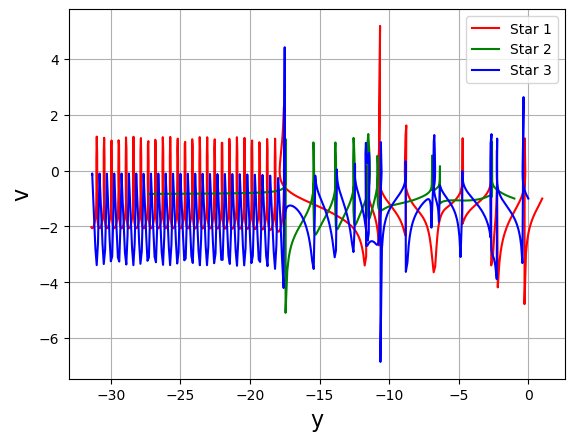

In [19]:
my_3_body_stellar_system3.plot_phase_plot_y()

## **Hypergiants System**

If I were to code the Hypergiant system I would make a new function in my Stellar System class to calculate the solution.

I would create an if statement:
- if a star's x and y position is close (this could be set to something low like 0.001) to another star's x and y position they will combine into one star. I would make the star with the smaller mass add onto the star with the larger mass, leaving the smaller star with mass zero and the larger star with mass $m_1 + m_2$. I would then recalculate the velocity to satisfy:  $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$. Continue calculating the solutions as if it was a 2 body system.
- else, continue as a 3 body problem 

Set initial masses to similar masses in a ratio